In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
   width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

# Librerias y funciones 

In [2]:
import numpy as np
import os
# Para correr en hilos la evaluación este parametro aumenta significativamente la velocidad de evaluacion
os.environ['OMP_THREAD_LIMIT'] = '1'

In [3]:
import pytesseract
from matplotlib import pyplot as plt
import cv2

In [4]:
from pipeline_img import PipelineImg

In [5]:
import os
# https://stackoverflow.com/a/9728478
def list_files(startpath):
    files_path = []
    for root, dirs, files in os.walk(startpath):
        for indx in range(len(files)):
            files_path.append(root+"/"+files[indx])
    return list(filter(lambda el: el.endswith("JPG"), files_path))

In [6]:
def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Cargando imagenes en la carpeta Ficheros

In [7]:
# Obtengo todas las imagenes que se descargaron
home_path = "/media/juan/jc/archivos_represion/Ficheros/"
imgs_paths = list_files(home_path)
print("{:,} imagenes encontradas dentro de la carpeta Ficheros".format(len(imgs_paths)))

18,008 imagenes encontradas dentro de la carpeta Ficheros



# Busqueda de hiperparametros
Algo que noté cuando realizaba la construcción de la clase <code>PipelineImg</code> es que los parametros para obtener una mejor lectura varian en gran medida de la resolución de la imagen y de la calidad de lo que rodea la hoja en la fotografía, controlo estos dos aspectos con el <b>resizing</b> y los <b>bordes</b>, en las siguientes celdas viene una busqueda de los "mejores" hiperparametros para las imagenes en función de la resolución de la imagen.




## Con 900px en height

-68.- Bl 24 actual "El Univ
ADIESTRAN CONUNISCAS EN ATO

 

nota
co involucia a oste cicconto,- La CCI do 'Garzón

“ díco desconocor cualquíor relación do osto clercl
“ 20 con ciombros del PCH, puos no tionon ligas co:
dicho Partico, y que de ser verdad lo dicho en
el periódico, so dostituir modiatarante de su
-actual puesto a este o..5……b:…o Exp.11-136-68.

. . H-96 1i-19.
9-700-68.-. So envió un boletín a diferantes dia-
' ríos capitalinos íntitulado "SAMUEL ADAME FLORES
: Ropto., da la CCT., en el Edo, de Cro.., "Ajeno to
! £almento en actos do ngitación".-Sec a…ao que al-
conprobar nsta Central su 1nocencia on los cargo


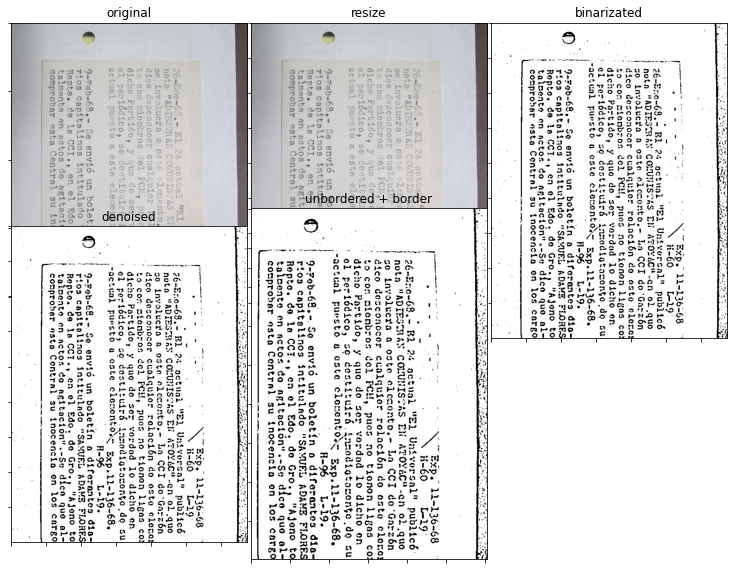

In [8]:
img = cv2.imread(imgs_paths[3])
pre_img = PipelineImg.do_full_pipeline(img, height=900,bordersize=15, auto_canny_sigma=0.33, debug=True)
config = ("-l spa --psm 1 ")
text = pytesseract.image_to_string(pre_img, config=config)
print(text.strip())

## Con 1200px en height

“x

 

— e UN Exp. 11-136-68
… AE “H-60 L-19- —
26-Ene-68.- El 24 actual “El Universal" publicó
nota "ADIESTRAN COLMUNISTAS EN ATOYAC" en el que -
se involucfa a este elemento,- La CCI de Garzón -
dice desconocer cualquier relación de este"eleme)
+to con miembros del PCI, pues no tienen ligas col
dicho Partido, y que de ser verdad lo dicho en

el periódico, se destituirá inmediatamente de su
-actual puesto a mmcm_mwmawñfo.w Exp.11-136-68:

. — .. H=96  L=19e. .
9-Feb-68,- Se envió un boletín a diferantes dia-
rios capitalinos- intitulado "SAMUEL ADAME FLORES
Repte. de la CCI., en.el Edo, de Gro., "Ajeno to
talmente en actos de agitación".-Se dice que al-
comprobar esta Central su inocencia en los cargo


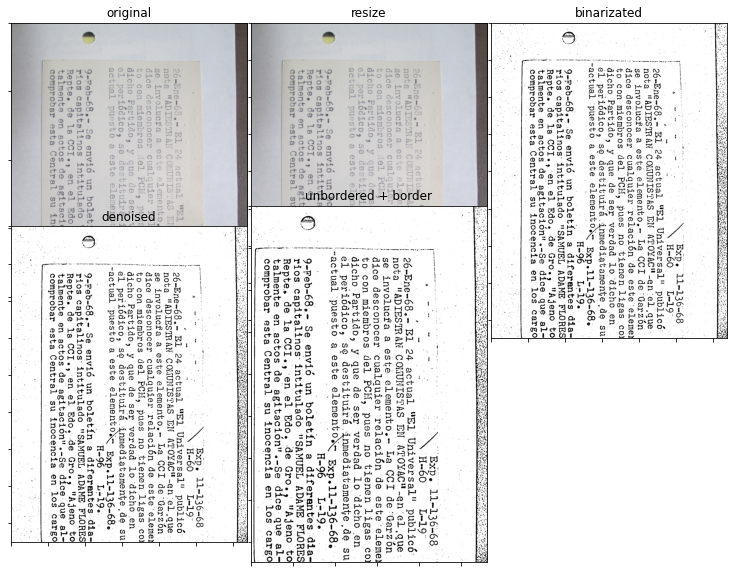

In [16]:
pre_img2 = PipelineImg.do_full_pipeline(img, height=1700, bordersize=15, auto_canny_sigma=0.33, debug=True)
config = ("-l spa --psm 1 ")
text = pytesseract.image_to_string(pre_img2, config=config)
print(text.strip())

Use una forma algo primitiva de detectar el expediente: <code>s_exp = lambda txt: re.search("(\d{1,3})(-)(\d{1,3})(-)(\w{1,3})", txt) if txt is not None else None</code>, teniendo el texto generado podremos aplicar mejor tecnicas de RegEx.

## Busqueda de hiperparametros

In [17]:
from sklearn.model_selection import ParameterGrid
import random
random.seed(1234)
param_grid = {'path':random.sample(imgs_paths,500), 'sigma': [0.33, 0.01], 'pixels' : [900, 1100, 1200, 1300, 1700], "border":[15,20,25]}
grid = ParameterGrid(param_grid)


In [18]:
len(list(grid))

15000

In [9]:
len(list(grid))

8000

In [19]:
import re
is_exp = lambda txt: re.search("(\d{1,3})(-)(\d{1,3})(-)(\w{1,3})", txt) if txt is not None else None
is_date = lambda txt: re.search("(\d{2})-([a-zA-Z]{3})-(\d{2})", txt) if txt is not None else None

def get_evaluation(indx):
    print(".", end="")
    grd = grid[indx]
    path, sigma, pixels, border = grd["path"], grd["sigma"], grd["pixels"], grd["border"]
    img = cv2.imread(path)
    final_img = PipelineImg.do_full_pipeline(img, debug=False,bordersize=border, auto_canny_sigma=sigma, height=pixels)
    
    config=None
    if img.shape[0]> img.shape[1]:
        config = ("-l spa --psm 1")
    else:
        config = ("-l spa --psm 6 ")
    text = pytesseract.image_to_string(final_img, config=config)
    print("-", end="")
    
    return (path, *img.shape, sigma, pixels, border, 0 if is_exp(text) is None else 1, 0 if is_date(text) is None else 1)
    

In [ ]:
import multiprocessing as mp
print("Procesando con {} nucleos".format(mp.cpu_count()))
pool = mp.Pool(mp.cpu_count())
results = pool.map(get_evaluation,[ indx for indx in range(len(list(grid)))])
pool.close()

Procesando con 8 nucleos
........-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

In [ ]:
import pandas as pd
df = pd.DataFrame(results,columns=["path","shape_a","shape_b", "shape_c","sigma","pixels","border","is_exp","is_date"])
df.to_csv("data/hp_tunning_500_v2.csv", index=False)

In [18]:
df.head(2)

,path,shape_a,shape_b,shape_c,sigma,pixels,border,is_exp,is_date
0,/media/juan/jc/archivos_represion/Ficheros/UPC...,3456,4608,3,0.33,900,5,0,0
1,/media/juan/jc/archivos_represion/Ficheros/UPC...,3456,4608,3,0.33,1100,5,0,0


In [14]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName('params').getOrCreate()

In [15]:
dataframe = spark.read.csv("data/hp_tunning_500_v2.csv", header=True)

In [16]:
from pyspark.sql import Window

### Los "mejores" parametros para cada resolución

In [20]:
wm = Window.partitionBy(F.col("shape_a"),F.col("shape_b")).orderBy(F.col("prop_exp").desc(), F.col("prop_date").desc())
dataframe.groupby(F.col("shape_a"),F.col("shape_b"), F.col("sigma"), F.col("pixels"), F.col("border")).agg(
(F.sum(F.col("is_exp"))/F.count("*")).alias("prop_exp"),
    (F.sum(F.col("is_date"))/F.count("*")).alias("prop_date"),
    F.count("*").alias("total")
).orderBy(F.col("prop_exp").desc()).withColumn("row_number", F.row_number().over(wm)).where(F.col("row_number")  == 1).show(truncate=False)

+-------+-------+-----+------+------+-------------------+-------------------+-----+----------+
|shape_a|shape_b|sigma|pixels|border|prop_exp           |prop_date          |total|row_number|
+-------+-------+-----+------+------+-------------------+-------------------+-----+----------+
|1728   |2304   |0.33 |1300  |10    |0.6633663366336634 |0.15841584158415842|101  |1         |
|2432   |4320   |0.33 |1100  |5     |0.7272727272727273 |0.18181818181818182|11   |1         |
|3456   |4608   |0.33 |1100  |5     |0.568359375        |0.09375            |512  |1         |
|2304   |1728   |0.33 |1300  |10    |0.2777777777777778 |0.05555555555555555|36   |1         |
|1944   |2592   |0.33 |1200  |10    |0.7092198581560284 |0.12056737588652482|141  |1         |
|4608   |3456   |0.33 |1300  |5     |0.16911764705882354|0.0                |136  |1         |
|3264   |2448   |0.33 |1200  |5     |0.13636363636363635|0.0                |44   |1         |
|2448   |3264   |0.33 |1200  |5     |0.57894736842

In [13]:
configs = [
    {"h":1728, "w":2304 , "sigma":0.33, "pixels":1300    ,"border":10   },
    {"h":2432, "w":4320 , "sigma":0.33, "pixels":1100    ,"border":5   },
    {"h":3456, "w":4608 , "sigma":0.33, "pixels":1100    ,"border":5   },
    {"h":2304, "w":1728 , "sigma":0.33, "pixels":1300    ,"border":10  },
    {"h":1944, "w":2592 , "sigma":0.33, "pixels":1200    ,"border":10  },
    {"h":4608, "w":3456 , "sigma":0.33, "pixels":1300    ,"border":5   },
    {"h":3264, "w":2448 , "sigma":0.33, "pixels":1200    ,"border":5   },
    {"h":2448, "w":3264 , "sigma":0.33, "pixels":1200    ,"border":5   }]
def get_nearest_conf(shape):
    return min(configs,key=lambda cnf: np.sqrt(((cnf["h"]-shape[0])**2)+((cnf["w"]-shape[1])**2)))

In [14]:
get_nearest_conf((1920,1080 ))

{'h': 2304, 'w': 1728, 'sigma': 0.33, 'pixels': 1300, 'border': 10}

1 CAVILA-JUAREZ Fausio -7- .. . ..Exp-100-10-1-67: —
D T H-264 Le2k,
. 26.-Juñ.-67.-Se-encuentra confeso de los delitos
— de DIFAMACION, ASOTIECION DELICTUOSA,-INJUREAS, *
=. DIFUSION DE IDEAS Y PLANES TENDIENTES A ALTERAR *
- EL.ORDEN Y LA PAZ DEL EDO., por lo que el 2K ac=
E tual- el Juez -LIC, HUGO FEREZ BAUTISTA probable= ;
. mente le. declare la formal prisiong _.
o T — Exp=100-10-1=-67, |
. H-271 Le2h. 1
1 27.-June-67,-El dia 2 actual a las 1l.00Frs, :
; “el Lic, HUCO PEREZ-BAUTISTA Jugz Mixto de Primer
; Instancia del Dto, Judicial de Bravo, Dicto aúio
i de Formal: prisjon en contra de ESTE ELZMENTO y :
: -otros con los que fue detenidoss, por los delitos
S . a R e - - . :


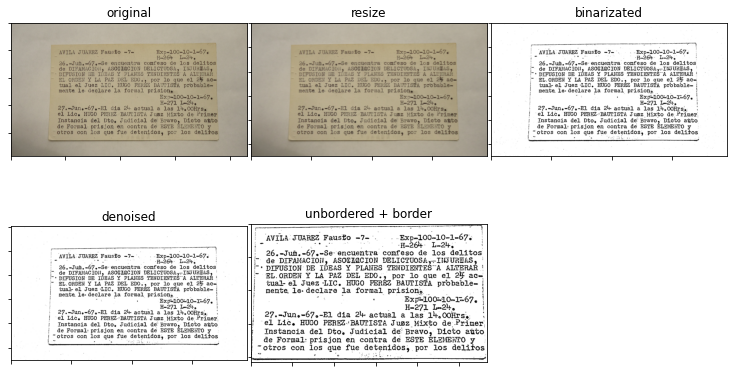

In [21]:
img = cv2.imread(imgs_paths[35])
conf = get_nearest_conf(img.shape)
pre_img = PipelineImg.do_full_pipeline(img, height=conf["pixels"],bordersize=conf["border"]+15 ,auto_canny_sigma=0.33, debug=True)
config = ("-l spa --psm 6 ")
text = pytesseract.image_to_string(pre_img, config=config)
print(text.strip())

1 CAVILA-JUAREZ Fausio -7- .. . ..Exp-100-10-1-67: —
D T H-264 Le2k,
. 26.-Juñ.-67.-Se-encuentra confeso de los delitos
— de DIFAMACION, ASOTIECION DELICTUOSA,-INJUREAS, *
=. DIFUSION DE IDEAS Y PLANES TENDIENTES A ALTERAR *
- EL.ORDEN Y LA PAZ DEL EDO., por lo que el 2K ac=
E tual- el Juez -LIC, HUGO FEREZ BAUTISTA probable= ;
. mente le. declare la formal prisiong _.
o T — Exp=100-10-1=-67, |
. H-271 Le2h. 1
1 27.-June-67,-El dia 2 actual a las 1l.00Frs, :
; “el Lic, HUCO PEREZ-BAUTISTA Jugz Mixto de Primer
; Instancia del Dto, Judicial de Bravo, Dicto aúio
i de Formal: prisjon en contra de ESTE ELZMENTO y :
; -otros con los que fue detenidoss, por los delitos
R . a R e - - . :


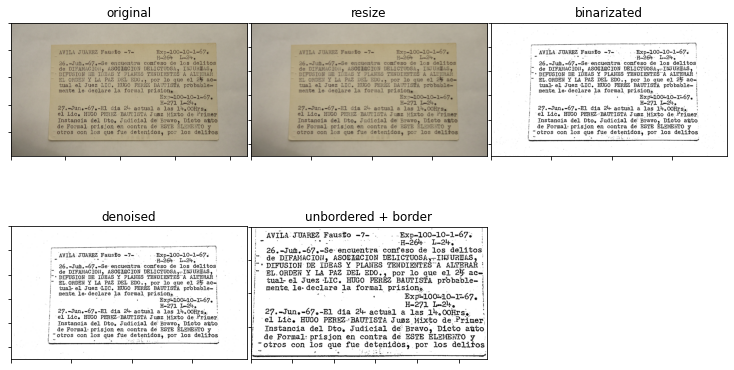

In [38]:
img = cv2.imread(imgs_paths[35])
conf = get_nearest_conf(img.shape)
pre_img = PipelineImg.do_full_pipeline(img, height=conf["pixels"],bordersize=conf["border"]+15 ,auto_canny_sigma=0.99, debug=True)
config = ("-l spa --psm 6 ")
text = pytesseract.image_to_string(pre_img, config=config)
print(text.strip())

# Etiquetando todas las imagenes